Chargement des librairies

In [1]:
import numpy as np
from scipy.stats import ttest_ind, t
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import convolve2d
import ot
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
top = cm.get_cmap('viridis', 64)

bottom = cm.get_cmap('plasma', 960)

newcolors = np.vstack((top(np.linspace(0, 1, 64)),

                       bottom(np.linspace(1, 0, 960))))

newcmp = ListedColormap(newcolors, name='MonteCarlo')

/tmp/ipykernel_6273/2658366827.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_6273/2658366827.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom = cm.get_cmap('plasma', 960)


On définit deux fonctions :
- **creation_matrice_ref** qui permet de générer une matrice de taille n x n qui correspond à la moyenne de 1000 matrices pour la zone extérieure, 10000 matrices pour la zone entre le centre et l'extérieur et 100000 matrices pour le centre. Les valeurs de chaque matrice sont simulées selon une loi normale centrée réduite.
- **creation_matrice_bruit** qui génère une matrice semblable à celle de creation_matrice_ref mais avec un bruit centré et d'écart-type sd en plus dans la zone verticale centrale.

In [3]:
def creation_matrice_ref(n):
    matrice_ref = np.zeros((n, n))
    matrices_simulees = [[[] for _ in range(n)] for _ in range(n)]
    matrice_taille_ech_aleatoire = np.zeros((n, n))
    matrice_ecart_type = np.ones((n, n))

    for i in range (n):
        for j in range (n):
            if (i < n//5 or i >= 4*n//5 or j < n//5 or j >= 4*n//5):
                taille_ech_aleatoire = np.random.randint(1, 400) + 800
            elif (i >= 2*n//5 and i < 3*n//5 and j >= 2*n//5 and j < 3*n//5):
                taille_ech_aleatoire = np.random.randint(1, 40000) + 80000
            else:
                taille_ech_aleatoire = np.random.randint(1, 4000) + 8000

            matrice_taille_ech_aleatoire[i][j] = taille_ech_aleatoire
            matrices_simulees[i][j].append(np.random.randn(taille_ech_aleatoire))
            matrice_ref[i][j] = np.array(matrices_simulees[i][j]).mean()

    return matrices_simulees, matrice_ref, matrice_taille_ech_aleatoire, matrice_ecart_type

def creation_matrice_bruit(n, sd):
    matrice_bruitee = np.zeros((n, n))
    matrices_simulees = [[[] for _ in range(n)] for _ in range(n)]
    matrice_taille_ech_aleatoire = np.zeros((n, n))
    matrice_ecart_type = np.ones((n, n))

    for i in range (n):
        for j in range (n):
            if (i < n//5 or i >= 4*n//5 or j < n//5 or j >= 4*n//5):
                taille_ech_aleatoire = np.random.randint(1, 400) + 800
                if (j < 11*n//20 and j >= 9*n//20):
                    matrice_ecart_type[i][j] += sd
                    matrices_simulees[i][j].append(np.random.normal(0, sd + 1, taille_ech_aleatoire))
                else:
                    matrices_simulees[i][j].append(np.random.randn(taille_ech_aleatoire))

            elif (i >= 2*n//5 and i < 3*n//5 and j >= 2*n//5 and j < 3*n//5):
                taille_ech_aleatoire = np.random.randint(1, 40000) + 80000
                if (j < 11*n//20 and j >= 9*n//20):
                    matrice_ecart_type[i][j] += sd
                    matrices_simulees[i][j].append(np.random.normal(0, sd + 1, taille_ech_aleatoire))
                else:
                    matrices_simulees[i][j].append(np.random.randn(taille_ech_aleatoire))

            else:
                taille_ech_aleatoire = np.random.randint(1, 4000) + 8000
                if (j < 11*n//20 and j >= 9*n//20):
                    matrice_ecart_type[i][j] += sd
                    matrices_simulees[i][j].append(np.random.normal(0, sd + 1, taille_ech_aleatoire))
                else:
                    matrices_simulees[i][j].append(np.random.randn(taille_ech_aleatoire))
            
            matrice_taille_ech_aleatoire[i][j] = taille_ech_aleatoire
            matrice_bruitee[i][j] = np.array(matrices_simulees[i][j]).mean()

    return matrices_simulees, matrice_bruitee, matrice_taille_ech_aleatoire, matrice_ecart_type

On définit les métriques classiques qui permettent d'évaluer la différence entre deux images (représentées ici par des matrices) :

In [4]:
def mse(A, B):
    return (A - B) ** 2

def mae(A, B):
    return np.abs(A - B)

# def t_test(matrices_simulees_ref, matrice_simulees_bruitee):
    t_test_matrix = np.zeros((100, 100))
    n, m = 100, 100

    for i in tqdm(range(n)):
        for j in range(m):
            x = np.array(matrices_simulees_ref[i][j]).ravel()
            y = np.array(matrice_simulees_bruitee[i][j]).ravel()
            pval = ttest_ind(x, y).pvalue
            
            if (pval < 0.05):
                t_test_matrix[i][j] = 1
            else:
                t_test_matrix[i][j] = 0

    return t_test_matrix


def t_test(matrice_ref, matrice_bruit, matrice_taille_ech_ref, matrice_taille_ech_bruit, matrice_ecart_type_ref, matrice_ecart_type_bruit, matrice_size = 100):
    t_test_matrix = np.zeros((matrice_size, matrice_size))

    for i in range(matrice_size):
        for j in range(matrice_size):
            mean1 = matrice_ref[i][j]
            mean2 = matrice_bruit[i][j]
            n1 = matrice_taille_ech_ref[i][j]
            n2 = matrice_taille_ech_bruit[i][j]
            sd1 = matrice_ecart_type_ref[i][j]
            sd2 = matrice_ecart_type_bruit[i][j]

            t_stat = (mean1 - mean2) / np.sqrt(sd1**2/n1 + sd2**2/n2)

            ddl = (sd1**2/n1 + sd2**2/n2)**2 / ((sd1**2/n1)**2/(n1-1) + (sd2**2/n2)**2/(n2-1))

            p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=ddl))
    
            if (p_value < 0.05):
                t_test_matrix[i][j] = 1
            else:
                t_test_matrix[i][j] = 0

    return t_test_matrix



def ssim(img1, img2, K1=0.01, K2=0.03, L=1, window_size=7, sigma=1):
    """
    Calcule le SSIM (Structural Similarity Index) entre deux images img1 et img2.

    Parameters :
        img1, img2 : images (matrices numpy)
        K1, K2     : constantes de stabilisation
        L          : plage dynamique des valeurs (ici on normalise donc L=1)
        window_size : taille du noyau gaussien utilisé pour lisser (fenêtre)
        sigma      : écart-type du noyau gaussien

    Return :
        SSIM moyen entre les deux images (float)
    """

    # Normalisation dans [0,1]
    def normalize(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    img1 = normalize(img1)
    img2 = normalize(img2)

    # Construction d'un noyau gaussien pour le lissage local
    half = window_size // 2
    coords = np.arange(-half, half+1)
    # Noyau gaussien : window[i, j] = exp(-(i² + j²) / (2 sigma²))
    window = np.exp(-(coords[:, None]**2 + coords[None, :]**2) / (2 * sigma**2))
    window /= np.sum(window)

    # Convolution avec gestion des bords
    # "same" : même taille que l’image
    # "symm" : symétrie des bords
    conv = lambda X: convolve2d(X, window, mode='same', boundary='symm')

    # Moyennes locales
    mu1 = conv(img1)
    mu2 = conv(img2)

    # Variances et covariance locales
    sigma1_sq = conv(img1**2) - mu1**2
    sigma2_sq = conv(img2**2) - mu2**2
    sigma12   = conv(img1 * img2) - mu1 * mu2

    # Termes de stabilisation (évite les divisions par zéro)
    C1 = (K1*L)**2
    C2 = (K2*L)**2

    # Formule du SSIM pixel par pixel
    ssim_map = ((2*mu1*mu2 + C1) * (2*sigma12 + C2)) / \
               ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))

    # Retourne le SSIM moyen sans les valeurs NaN aux bords
    return ssim_map



def gamma_index(A, B, dose_diff_crit=0.03, dist_crit=3, pixel=1):
    """
    Calcule l'indice gamma entre deux matrices A et B qui représentent des cartes de dose.

    Parameters :
    -----------
    A, B : matrices numpy
    dose_diff_crit : float
        Critère de différence de dose 
    dist_crit : float
        Critère de glissement spatial entre les pixels (mm)
    pixel : float
        Taille d’un pixel (mm), utilisé pour convertir en distance réelle

    Return :
    --------
    gamma_map : matrice contenant, pour chaque pixel (i,j),
                la valeur minimale du gamma par rapport à tous les autres.
    """

    # Dimensions des matrices
    nr, nc = A.shape

    # Meshgrid permet de vectoriser les calculs de distance
    x = np.arange(nr)
    y = np.arange(nc)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Carte gamma initialisée à zéro (remplie pixel par pixel)
    gamma_map = np.zeros((nr, nc))

    for i in range(nr):
        for j in range(nc):
            # Calcul des distances et différences de dose entre le pixel (i,j) de la matrice A
            # et tous les pixels de la matrice B
            dist = np.sqrt((pixel * (X - i))**2 + (pixel * (Y - j))**2)
            dose_diff = np.abs(A[i, j] - B)

            # Calcul de la matrice gamma pour le pixel (i,j)
            gamma_matrix = np.sqrt(
                (dose_diff / dose_diff_crit)**2 +
                (dist / dist_crit)**2
            )

            # Valeur minimale du gamma pour le pixel (i,j)
            gamma_map[i, j] = np.min(gamma_matrix)

    return gamma_map

In [25]:
def create_fdr_optimized(cdf, ech, t):
    """
    Crée la fonction de répartition inverse
    """
    # Trouver les indices correspondants dans t pour chaque valeur de cdf
    cdf_index = np.searchsorted(t, cdf, side='left')
    
    F = np.zeros(len(t), dtype=ech.dtype)
    
    start_idx = 0
    for i, idx in enumerate(cdf_index):
        F[start_idx:idx+1] = ech[i]
        start_idx = idx + 1
    
    return F


def calculate_k_optimized(t):
    # Calcule les différences entre éléments consécutifs
    k = np.diff(t, prepend=0)
    return k


def wasserstein_one_pixel(ech1, ech2):
    ech1 = np.asarray(ech1, dtype=np.float32).ravel()
    ech2 = np.asarray(ech2, dtype=np.float32).ravel()
    
    # Trier les distributions
    ech1_trie = np.sort(ech1)
    ech2_trie = np.sort(ech2)
    
    n1, n2 = len(ech1_trie), len(ech2_trie)
    
    # Créer les CDF empiriques (version optimisée)
    cdf_1 = np.arange(1, n1 + 1, dtype=np.float32) / n1
    cdf_2 = np.arange(1, n2 + 1, dtype=np.float32) / n2
    
    # Combiner et obtenir valeurs uniques
    t = np.unique(np.concatenate([cdf_1, cdf_2]))
    
    # Créer les fonctions de répartition inverses
    ech1_q = create_fdr_optimized(cdf_1, ech1_trie, t)
    ech2_q = create_fdr_optimized(cdf_2, ech2_trie, t)
    
    # Calculer k
    k = calculate_k_optimized(t)
    
    # Distance de Wasserstein
    wasserstein_empirique = np.sum(np.abs(ech1_q - ech2_q) * k)
    
    return wasserstein_empirique


def wasserstein(matrices_simulees_ref, matrices_simulees_bruitees, 
                                     matrice_size=100):

    wasserstein_map = np.zeros((matrice_size, matrice_size))
      
    for i in tqdm(range(matrice_size), desc="Calcul Wasserstein"):
        for j in range(matrice_size):
            if isinstance(matrices_simulees_ref, dict):
                key = str(i) + str(j)
                wasserstein_map[i, j] = wasserstein_one_pixel(
                    matrices_simulees_ref[key],
                    matrices_simulees_bruitees[key]
                )
            else:
                wasserstein_map[i, j] = wasserstein_one_pixel(
                    matrices_simulees_ref[i][j],
                    matrices_simulees_bruitees[i][j]
                )
    
    return wasserstein_map

On exécute les fonctions en utilisant des matrices carrées de longueur n = 100.

In [7]:
np.random.seed(123)
n = 100

matrices_simulees_ref, matrice_reference, matrice_taille_ech_ref, matrice_ecart_type_ref = creation_matrice_ref(n)
matrices_simulees_bruitees, matrice_bruitee, matrice_taille_ech_bruit, matrice_ecart_type_bruit = creation_matrice_bruit(n, 0.05)

In [12]:
MSE = mse(matrice_reference, matrice_bruitee)
MAE = mae(matrice_reference, matrice_bruitee)
SSIM = ssim(matrice_reference, matrice_bruitee)
GAMMA_INDEX = gamma_index(matrice_reference, matrice_bruitee)
WASSERSTEIN = wasserstein(matrices_simulees_ref, matrices_simulees_bruitees)
TTEST = t_test(matrice_reference, matrice_bruitee, matrice_taille_ech_ref, matrice_taille_ech_bruit, matrice_ecart_type_ref, matrice_ecart_type_bruit)

Calcul Wasserstein: 100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


In [13]:
def affichage_matrices(matrice_reference, matrice_bruitee, matrice_metrique, metrique_name):
    #plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Référence")
    plt.imshow(matrice_reference, cmap=newcmp)
    #plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("matrice bruitée")
    plt.imshow(matrice_bruitee, cmap=newcmp)
    #plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title(f"matrice métrique : {metrique_name}")
    plt.imshow(matrice_metrique, cmap=newcmp)
    #plt.colorbar()

    plt.tight_layout()
    plt.show()

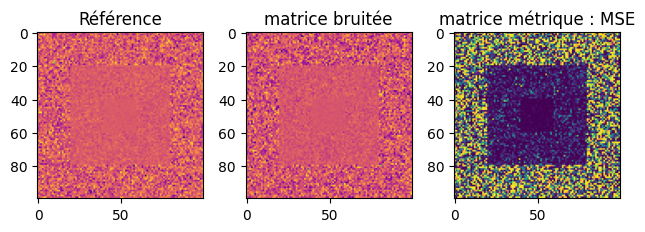

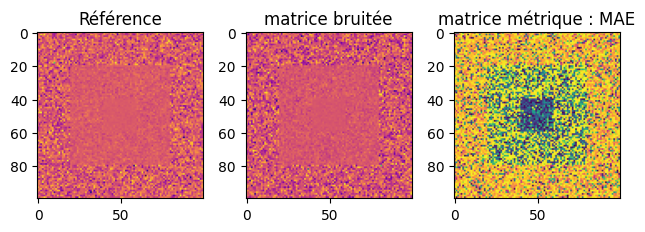

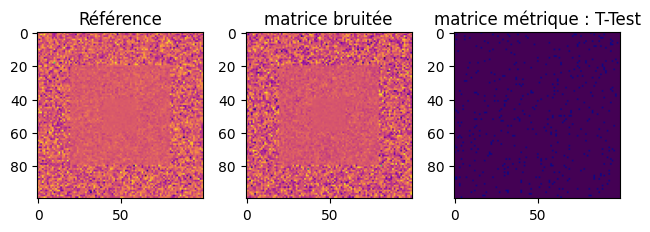

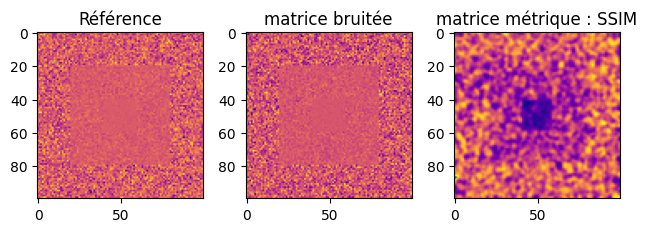

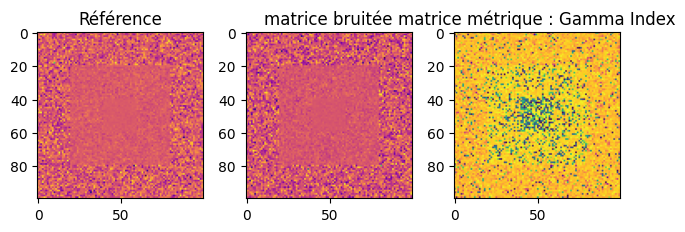

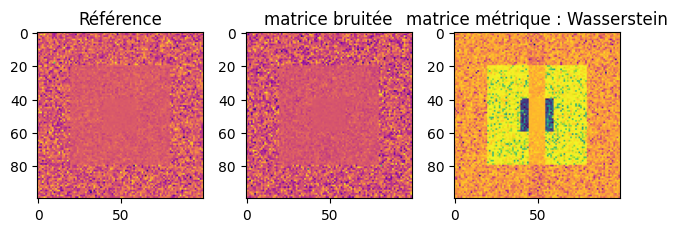

In [14]:
affichage_matrices(matrice_reference, matrice_bruitee, MSE, "MSE")
affichage_matrices(matrice_reference, matrice_bruitee, MAE, "MAE")
affichage_matrices(matrice_reference, matrice_bruitee, TTEST, "T-Test")
affichage_matrices(matrice_reference, matrice_bruitee, SSIM, "SSIM")
affichage_matrices(matrice_reference, matrice_bruitee, GAMMA_INDEX, "Gamma Index")
affichage_matrices(matrice_reference, matrice_bruitee, WASSERSTEIN, "Wasserstein")


In [15]:
# 2ème version de la génération des matrices pour ajouter du bruit (écart-type tiré aléatoirement pour chaque point)

def create_data(size_carte, niveauBiais) :

 
   #Matrice des variances et moyennes : modèle
   mat_variance = np.abs(np.random.normal(0, 1, size=(size_carte, size_carte)))
   mat_moyenne = np.abs(np.random.normal(0, 1, size=(size_carte, size_carte)))

   #Matrice des nombres d'échantillons
   mat_nombres_ech1 = np.random.randint(100, 120, (size_carte,size_carte)) 
   mat_nombres_ech2 = mat_nombres_ech1 + np.random.randint(-10, 10, (size_carte, size_carte))


   taille=mat_nombres_ech1[9:55,9:55].shape
   mat_nombres_ech1[9:55,9:55] = np.random.randint(1000, 1200, (taille)) 
   mat_nombres_ech2[9:55,9:55] = mat_nombres_ech1[9:55,9:55] + np.random.randint(-50, 50, (taille)) 

   taille=mat_nombres_ech1[18:46,18:46].shape
   mat_nombres_ech1[18:46,18:46] = np.random.randint(5000, 5500, (taille)) 
   mat_nombres_ech2[18:46,18:46] = mat_nombres_ech1[18:46,18:46] + np.random.randint(-200, 200, (taille)) 

   taille=mat_nombres_ech1[27:37,27:37].shape
   mat_nombres_ech1[27:37,27:37] = np.random.randint(10000, 11000, (taille)) 
   mat_nombres_ech2[27:37,27:37] = mat_nombres_ech1[27:37,27:37] + np.random.randint(-1000, 1000, (taille)) 


   # Générer les cartes 

   stock1={}
   stock2={}
   carte1 = np.zeros((size_carte,size_carte))
   carte2 = np.zeros((size_carte,size_carte))
   var_carte1= np.zeros((size_carte,size_carte))
   var_carte2= np.zeros((size_carte,size_carte))


   for l in range(size_carte):
      for c in range(size_carte):
         stock1[str(l)+str(c)] = np.abs(np.random.normal(mat_variance[l,c], mat_moyenne[l,c], mat_nombres_ech1[l,c]))
         stock2[str(l)+str(c)] = np.abs(np.random.normal(mat_variance[l,c], mat_moyenne[l,c], mat_nombres_ech2[l,c]))
         
         #bruit = np.random.normal(0, 0.005, mat_nombres_ech2[l,c])
         #stock2[str(l)+str(c)] = stock2[str(l)+str(c)]#+ bruit
         
         stock1[str(l)+str(c)] = stock1[str(l)+str(c)]/(stock1[str(l)+str(c)].max())
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)]/(stock2[str(l)+str(c)].max())


         carte1[l,c] = np.mean(stock1[str(l)+str(c)])
         var_carte1[l,c] = np.std(stock1[str(l)+str(c)])

         carte2[l,c] = np.mean(stock2[str(l)+str(c)])
         var_carte2[l,c] = np.std(stock2[str(l)+str(c)])

   #Ajoute biais

   for l in range(size_carte):
      for c in range(30,35):
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)] + niveauBiais
         stock2[str(l)+str(c)] = stock2[str(l)+str(c)]/(stock2[str(l)+str(c)].max())
         carte2[l,c] = np.mean(stock2[str(l)+str(c)])
         var_carte2[l,c] = np.std(stock2[str(l)+str(c)])


   
   return carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, var_carte1, var_carte2, stock1, stock2

In [22]:
carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, std_carte1, std_carte2, stock1, stock2 = create_data(64, 0.05)

In [23]:
MSE_bis = mse(carte1, carte2)
MAE_bis = mae(carte1, carte2)
SSIM_bis = ssim(carte1, carte2)
GAMMA_INDEX_bis = gamma_index(carte1, carte2)
WASSERSTEIN_bis = wasserstein(stock1, stock2, 64)
TTEST_bis = t_test(carte1, carte2, mat_nombres_ech1, mat_nombres_ech2, std_carte1, std_carte2, 64)

Calcul Wasserstein: 100%|██████████| 64/64 [00:09<00:00,  6.81it/s]


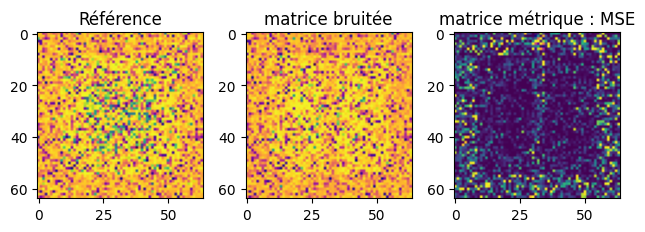

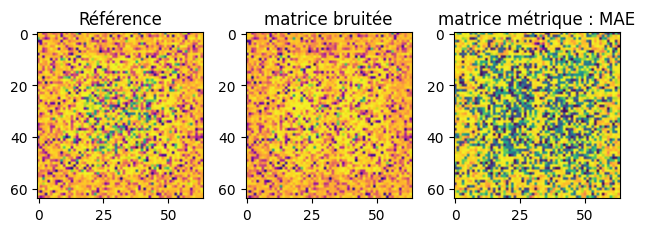

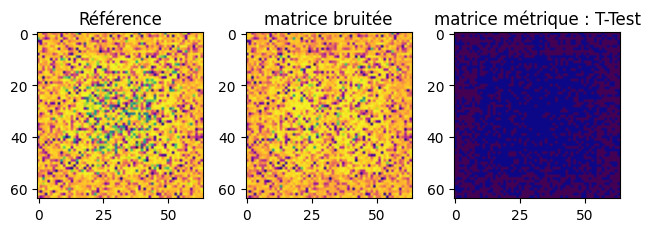

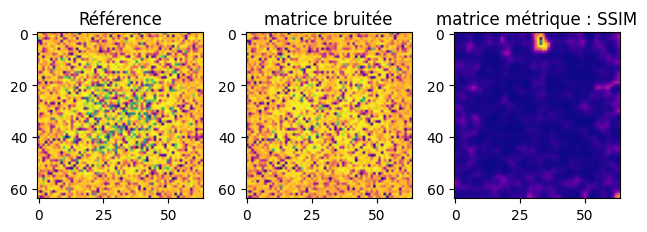

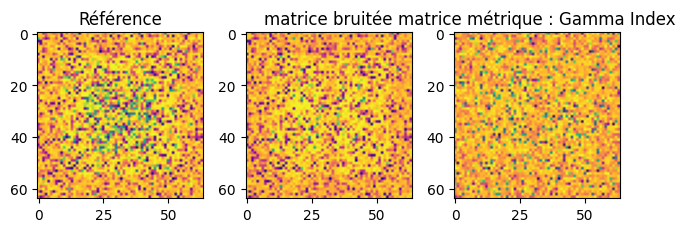

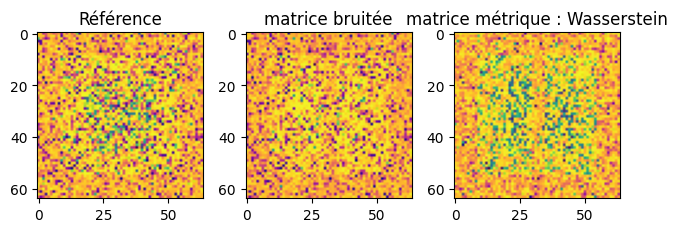

In [24]:
affichage_matrices(carte1, carte2, MSE_bis, "MSE")
affichage_matrices(carte1, carte2, MAE_bis, "MAE")
affichage_matrices(carte1, carte2, TTEST_bis, "T-Test")
affichage_matrices(carte1, carte2, SSIM_bis, "SSIM")
affichage_matrices(carte1, carte2, GAMMA_INDEX_bis, "Gamma Index")
affichage_matrices(carte1, carte2, WASSERSTEIN_bis, "Wasserstein")
